In [1]:
from pathlib import Path

import yaml
import torch
from omegaconf import DictConfig
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)

from src.datamodule import SleepDataModule
# from src.modelmodule.seg import class SegValidDataset(Dataset):



# def main(cfg: dict):  # type: ignore
#     seed_everything(cfg.seed)

#     # init lightning model
#     datamodule = SegDataModule(cfg)
#     # LOGGER.info("Set Up DataModule")
#     model = SegModel(
#         cfg, datamodule.valid_event_df, len(cfg.features), len(cfg.labels), cfg.duration
#     )

#     # set callbacks
#     checkpoint_cb = ModelCheckpoint(
#         verbose=True,
#         monitor=cfg.monitor,
#         mode=cfg.monitor_mode,
#         save_top_k=1,
#         save_last=False,
#     )
#     lr_monitor = LearningRateMonitor("epoch")
#     progress_bar = RichProgressBar()
#     model_summary = RichModelSummary(max_depth=2)

#     trainer = Trainer(
#         # env
#         default_root_dir=Path.cwd(),
#         # num_nodes=cfg.training.num_gpus,
#         accelerator=cfg.accelerator,
#         precision=16 if cfg.use_amp else 32,
#         # training
#         fast_dev_run=cfg.debug,  # run only 1 train batch and 1 val batch
#         max_epochs=cfg.epoch,
#         max_steps=cfg.epoch * len(datamodule.train_dataloader()),
#         gradient_clip_val=cfg.gradient_clip_val,
#         accumulate_grad_batches=cfg.accumulate_grad_batches,
#         callbacks=[checkpoint_cb, lr_monitor, progress_bar, model_summary],
#         logger=None,
#         # resume_from_checkpoint=resume_from,
#         num_sanity_val_steps=0,
#         log_every_n_steps=int(len(datamodule.train_dataloader()) * 0.1),
#         sync_batchnorm=True,
#         check_val_every_n_epoch=cfg.check_val_every_n_epoch,
#     )

#     trainer.fit(model, datamodule=datamodule)

#     # load best weights
#     model = model.load_from_checkpoint(
#         checkpoint_cb.best_model_path,
#         cfg=cfg,
#         val_event_df=datamodule.valid_event_df,
#         feature_dim=len(cfg.features),
#         num_classes=len(cfg.labels),
#         duration=cfg.duration,
#     )
#     weights_path = str("model_weights.pth")  # type: ignore

#     torch.save(model.model.state_dict(), weights_path)

#     return

cfg = yaml.safe_load(Path('conf/train.yaml').read_text())
cfg_dir = yaml.safe_load(Path('conf/dir/local.yaml').read_text())
cfg_split = yaml.safe_load(Path('conf/split/fold_0.yaml').read_text())
cfg_model = yaml.safe_load(Path('conf/model/Spec2DCNN.yaml').read_text())
cfg_fe = yaml.safe_load(Path('conf/feature_extractor/CNNSpectrogram.yaml').read_text())
cfg_de = yaml.safe_load(Path('conf/decoder/UNet1DDecoder.yaml').read_text())
cfg_ds = yaml.safe_load(Path('conf/dataset/seg.yaml').read_text())

cfg['dir'] = cfg_dir
cfg['split'] = cfg_split
cfg['model'] = cfg_model
cfg['feature_extractor'] = cfg_fe
cfg['decoder'] = cfg_de
cfg['dataset'] = cfg_ds

cfg = DictConfig(cfg)

# main(cfg)

datamodule = SleepDataModule(cfg)

x = datamodule.train_dataloader()


In [2]:
l = None

for i in x:
    l = i['label']
    break

In [25]:
import numpy as np

y = l[0,:,0].numpy()

def gaussian_kernel(length: int, sigma: int = 3) -> np.ndarray:
    x = np.ogrid[-length : length + 1]
    h = np.exp(-(x**2) / (2 * sigma * sigma))  # type: ignore
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def add_gaussian_sleep(label, offset=20):
    idxs = np.where(np.diff(label) == 1)
    
    for idx in idxs:
        if len(idx) > 0:
            idx = idx[0]

            z = gaussian_kernel(offset*2, sigma=offset//2)[:offset*2]
            
            if idx-offset < 0:
                z = z[offset-idx:]
            elif idx+offset > label.shape[0]:
                z = z[:label.shape[0]-idx-offset]

            label[max(idx-offset, 0):min(idx+offset, label.shape[0])] = z

    idxs = np.where(np.diff(label) == -1)
    
    for idx in idxs:
        if len(idx) > 0:
            idx = idx[0]

            z = gaussian_kernel(offset*2, sigma=offset//2)[offset*2-1:]
            
            if idx-offset < 0:
                z = z[offset-idx:]
            elif idx+offset > label.shape[0]:
                z = z[:label.shape[0]-idx-offset]

            label[max(idx-offset, 0):min(idx+offset, label.shape[0])] = z

    return label

y = add_gaussian_sleep(y)


(array([2963]),)


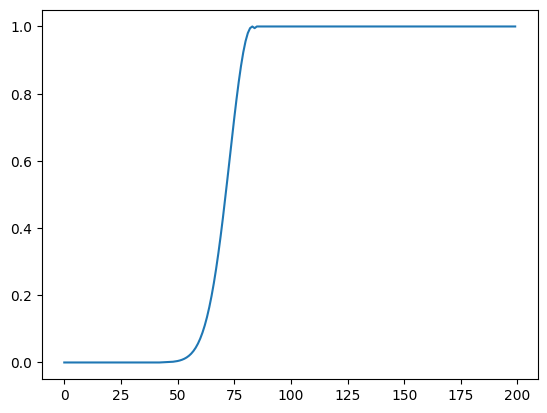

In [26]:
import matplotlib.pyplot as plt

plt.plot(y[2900:3100])